In [ ]:
!pip install pystac_client stackstac rio-tiler

### Querying the AWS STAc API with Pystac Client

In [2]:
import os
from pystac_client import Client
import stackstac
# making a connection to AWS STAC API
API_ROOT_URL = "https://1hfhn8bf6g.execute-api.us-west-2.amazonaws.com"
client = Client.open(API_ROOT_URL)

# our search requirements, a bounding box for San Ignacio. Belize
bbox = [-89.09605011359278, 17.128707271735962, -89.04369134663197, 17.163285211322446]
source_search = client.search(
        collections=["cop-dem-glo-30"], bbox=bbox
    )

### Loading DEM raster into an Xarray DataArray

In [21]:
# getting the metadata and links to data assets in STAC format
source_items = source_search.get_all_items()

# converting STAC items into an xarray data array, then computing weekly composites
stack = stackstac.stack(source_items, epsg = 4326)

print(type(stack))

<class 'xarray.core.dataarray.DataArray'>


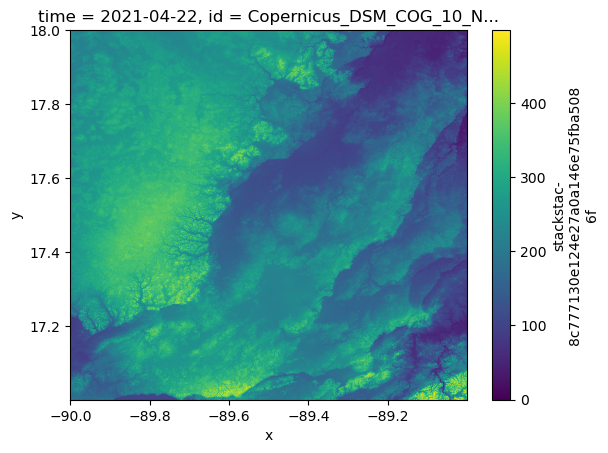

In [3]:
stack.plot()

### Loading an OSM descriptive Map of the same area

In [27]:
center_point = ((bbox[1] + bbox[3])/2, (bbox[0] + bbox[2])/2)
center_point

(17.145996241529204, -89.06987073011237)

In [26]:
from ipyleaflet import Map, basemaps, basemap_to_tiles

m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=center_point,
    zoom=11,
    )
m

Map(center=[17.145996241529204, -89.06987073011237], controls=(ZoomControl(options=['position', 'zoom_in_text'…